<a href="https://colab.research.google.com/github/leogalbu/Mineral-Rocks-Image-Classification/blob/Model_1_Quartz_Pyrite_Binary/Model_1_Quartz_Pyrite_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import numpy as np

## Keras
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten
from keras import Sequential

## Download the data

In [2]:
!wget https://www.dropbox.com/s/dq4wf6crqg8ecqv/QuartzPyriteImages.rar

--2022-09-08 07:27:43--  https://www.dropbox.com/s/dq4wf6crqg8ecqv/QuartzPyriteImages.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/dq4wf6crqg8ecqv/QuartzPyriteImages.rar [following]
--2022-09-08 07:27:44--  https://www.dropbox.com/s/raw/dq4wf6crqg8ecqv/QuartzPyriteImages.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca22bf3dc544a1e01ec88685e4e.dl.dropboxusercontent.com/cd/0/inline/BsgNHUy0sVRJV7fDy8rQ3bDvod20-fwxXLFPRs0y2nT0G3tITZa9SVuSp3tV46JfQvliV1ikremOKgwQkWpZkaNWUrFSN1-tGOveRtmTZehSLGEDAHb8qEdf2yxM2X0aF3J-ngaZ5boaiOXJpYlwEa34PMdYAYTyh4i--cS6YYfI4Q/file# [following]
--2022-09-08 07:27:45--  https://uca22bf3dc544a1e01ec88685e4e.dl.dropboxusercontent.com/cd/0/inline/BsgNHUy0sVRJV7fDy8rQ3bDvod20-fwxXLFPRs0y2nT0G3t

## Extract the dataset

In [3]:
!unrar x "/content/QuartzPyriteImages.rar" "/content/QuartzPyriteImages/";


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/QuartzPyriteImages.rar

Creating    /content/QuartzPyriteImages                               OK
Creating    /content/QuartzPyriteImages/train                         OK
Creating    /content/QuartzPyriteImages/train/Pyrite                  OK
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1.jpg          0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1002.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1004.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1005.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1007.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1008.jpg       0%  OK 
Extracting  /content/QuartzPyriteImages/train/Pyrite/Pyrite_1011.jpg       0%  OK 
Extracting  /conten

## Setting the train, validation and test directory

In [4]:
train_dir = 'QuartzPyriteImages/train'
val_dir = 'QuartzPyriteImages/validation'
test_dir = 'QuartzPyriteImages/test'

## Scanning the directories (Before checking the correct images)

In [5]:
for dirpath, dirnames, filenames in os.walk('QuartzPyriteImages'):
  print(f"the are {len(dirnames)} directories, and {len(filenames)} images in '{dirpath}'")

the are 3 directories, and 0 images in 'QuartzPyriteImages'
the are 2 directories, and 0 images in 'QuartzPyriteImages/validation'
the are 0 directories, and 260 images in 'QuartzPyriteImages/validation/Pyrite'
the are 0 directories, and 238 images in 'QuartzPyriteImages/validation/Quartz'
the are 2 directories, and 0 images in 'QuartzPyriteImages/test'
the are 0 directories, and 260 images in 'QuartzPyriteImages/test/Pyrite'
the are 0 directories, and 238 images in 'QuartzPyriteImages/test/Quartz'
the are 2 directories, and 0 images in 'QuartzPyriteImages/train'
the are 0 directories, and 778 images in 'QuartzPyriteImages/train/Pyrite'
the are 0 directories, and 713 images in 'QuartzPyriteImages/train/Quartz'


## Scanning all the images and remove the not formatted well

In [26]:
from struct import unpack
from tqdm import tqdm_notebook
import pathlib
data_dir = pathlib.Path(val_dir)
data_dir

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                raise TypeError("issue reading jpeg file")       


bads = []

for img in tqdm_notebook(list(data_dir.glob('*/*.jpg'))):
    image = str(img)
    image = JPEG(image) 
    try:
        image.decode()   
    except:
        os.remove(img)
        bads.append(img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/498 [00:00<?, ?it/s]

## Scanning the directories (After checking the correct images)

In [27]:
for dirpath, dirnames, filenames in os.walk('QuartzPyriteImages'):
  print(f"the are {len(dirnames)} directories, and {len(filenames)} images in '{dirpath}'")

the are 3 directories, and 0 images in 'QuartzPyriteImages'
the are 2 directories, and 0 images in 'QuartzPyriteImages/validation'
the are 0 directories, and 237 images in 'QuartzPyriteImages/validation/Pyrite'
the are 0 directories, and 236 images in 'QuartzPyriteImages/validation/Quartz'
the are 2 directories, and 0 images in 'QuartzPyriteImages/test'
the are 0 directories, and 240 images in 'QuartzPyriteImages/test/Pyrite'
the are 0 directories, and 236 images in 'QuartzPyriteImages/test/Quartz'
the are 2 directories, and 0 images in 'QuartzPyriteImages/train'
the are 0 directories, and 693 images in 'QuartzPyriteImages/train/Pyrite'
the are 0 directories, and 708 images in 'QuartzPyriteImages/train/Quartz'


## Loading Datasets with image_dataset_from_directory

In [28]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
print('Setting up Training data')
train_data_set = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary')
print('Setting up Validation data')
validation_data_set = tf.keras.preprocessing.image_dataset_from_directory(val_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary')
print('Setting up Test data')
test_data_set = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, label_mode='binary')

Setting up Training data
Found 1401 files belonging to 2 classes.
Setting up Validation data
Found 473 files belonging to 2 classes.
Setting up Test data
Found 476 files belonging to 2 classes.


## View Random Image

In [12]:
class_names = train_data_set.class_names

def random_image_picker(target_dir, target_class):
  target_folder = target_dir + '/' + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  #print(f"Image shape: {img.shape}")

  return img

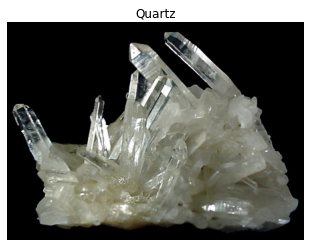

In [ ]:
img = random_image_picker("QuartzPyriteImages/train", "Quartz")

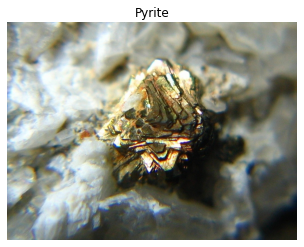

In [ ]:
img = random_image_picker("QuartzPyriteImages/train", "Pyrite")

In [60]:
class_names = train_data_set.class_names
class_names


AttributeError: ignored

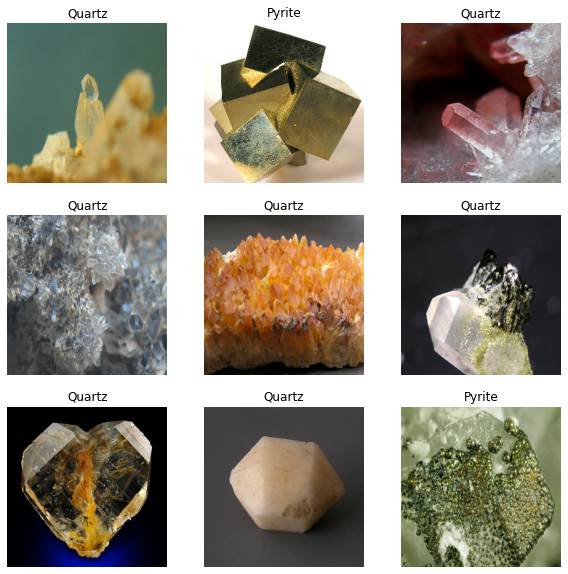

In [82]:
class_names = train_data_set.class_names
plt.figure(figsize=(10,10))
for images, labels in train_data_set.take(1):
  lbl = labels.numpy().ravel().astype('int')
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[lbl[i]])
    plt.axis('off')

## Build the Base CNN Model from Scratch (No data augmentation)

In [36]:
from tensorflow.keras.layers.experimental import preprocessing

model_1_baseline = Sequential([
    preprocessing.Rescaling(1./255),
    Conv2D(32,3, input_shape=(224,224,3), activation='relu'),
    Conv2D(32,3, activation='relu'),
    MaxPool2D(),
    Conv2D(64,3,activation='relu'),
    Conv2D(64,3, activation='relu'),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu'),
    Conv2D(128, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(256,3, activation='relu'),
    Conv2D(256,3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model_1_baseline.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam())

In [ ]:
# Fit the Model
history_1_baseline = model_1_baseline.fit(train_data_set, epochs=20, steps_per_epoch=len(train_data_set), validation_data=validation_data_set, validation_steps=len(validation_data_set))

Epoch 1/20
44/44 [==============================] - 170s 4s/step - loss: 0.5217 - accuracy: 0.7466 - val_loss: 0.3929 - val_accuracy: 0.8424
Epoch 2/20
44/44 [==============================] - 169s 4s/step - loss: 0.4696 - accuracy: 0.7923 - val_loss: 0.4202 - val_accuracy: 0.8193
Epoch 3/20
44/44 [==============================] - 169s 4s/step - loss: 0.4085 - accuracy: 0.8273 - val_loss: 0.3944 - val_accuracy: 0.8319
Epoch 4/20
44/44 [==============================] - 169s 4s/step - loss: 0.4156 - accuracy: 0.8230 - val_loss: 0.3561 - val_accuracy: 0.8613
Epoch 5/20
44/44 [==============================] - ETA: 0s - loss: 0.3557 - accuracy: 0.8387

KeyboardInterrupt: ignored